In [1]:
#telco_final_report

# Telco Classification Project

- James Allen

## Find drivers of customer churn.

## Why are customers churning?

In [2]:
#imports
import warnings
warnings.filterwarnings("ignore")
from env import host, user, password
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text, export_graphviz
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import os

import acquire
from prepare import prep_telco
import explore

## Project Plan

- Aquire Telco data
- Clean and prep telco data
- Establish hypothesis
- Train on classification models
- Evaluate and use on test dataset
- Create csv file with predicted churn
- Conclusion with takeaways and next steps

In [3]:
# aquire telco data
df = acquire.get_telco_churn_data()

In [4]:
df.head() #check_yo_head

,payment_type_id,contract_type_id,internet_service_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,internet_service_type,contract_type,payment_type
0,2,1,3,0030-FNXPP,Female,0,No,No,3,Yes,...,No internet service,No internet service,No internet service,No,19.85,57.2,No,None,Month-to-month,Mailed check
1,2,1,3,0031-PVLZI,Female,0,Yes,Yes,4,Yes,...,No internet service,No internet service,No internet service,No,20.35,76.35,Yes,None,Month-to-month,Mailed check
2,1,1,3,0098-BOWSO,Male,0,No,No,27,Yes,...,No internet service,No internet service,No internet service,Yes,19.40,529.8,No,None,Month-to-month,Electronic check
3,1,1,3,0107-WESLM,Male,0,No,No,1,Yes,...,No internet service,No internet service,No internet service,Yes,19.85,19.85,Yes,None,Month-to-month,Electronic check
4,3,1,3,0114-RSRRW,Female,0,Yes,No,10,Yes,...,No internet service,No internet service,No internet service,Yes,19.95,187.75,No,None,Month-to-month,Bank transfer (automatic)


In [5]:
df.shape # checking the shape of telco data

(7043, 24)

In [6]:
df.describe() # getting some intitial stats

,payment_type_id,contract_type_id,internet_service_type_id,senior_citizen,tenure,monthly_charges
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,2.315633,1.690473,1.872923,0.162147,32.371149,64.761692
std,1.148907,0.833755,0.737796,0.368612,24.559481,30.090047
min,1.000000,1.000000,1.000000,0.000000,0.000000,18.250000
25%,1.000000,1.000000,1.000000,0.000000,9.000000,35.500000
50%,2.000000,1.000000,2.000000,0.000000,29.000000,70.350000
75%,3.000000,2.000000,2.000000,0.000000,55.000000,89.850000
max,4.000000,3.000000,3.000000,1.000000,72.000000,118.750000


In [7]:
no_churn = df[df['churn'] == 'No'] # looking at the customers who have not churned
no_churn.churn.count() # count of customers that have not churned

5174

In [8]:
yes_churn = df[df['churn'] == 'Yes'] # looking at the customers who have churned
yes_churn.churn.count() # count of customers who have churned

1869

In [9]:
print('The number of customers that have churned is', yes_churn.churn.count())
print('The number of customers that remain is', no_churn.churn.count())

The number of customers that have churned is 1869
The number of customers that remain is 5174


<AxesSubplot:xlabel='churn', ylabel='count'>

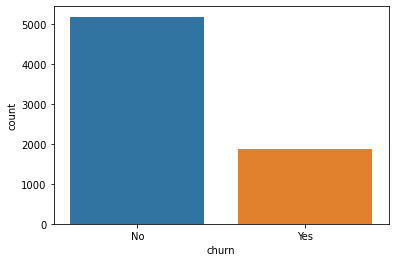

In [10]:
#making a graph to look at churn
sns.countplot(df['churn'])

### Acquire Notes

- Brought in telco data from codeup database using get_connection
- Telco data has 5 rows, 24 columns and a shape of (7043, 24)
- The number of customers that have churned is 1869
- The number of customers the have remain is 5174

## Prepare

In [11]:
# bringin in prep_telco function from prepare.py
prep_telco(df)

In [12]:
# splitting the data
def train_validate_test_split(df, target, seed=123):
    '''
    This function takes in a dataframe, the name of the target variable
    (for stratification purposes), and an integer for a setting a seed
    and splits the data into train, validate and test. 
    Test is 20% of the original dataset, validate is .30*.80= 24% of the 
    original dataset, and train is .70*.80= 56% of the original dataset. 
    The function returns, in this order, train, validate and test dataframes. 
    '''
    train_validate, test = train_test_split(df, test_size=0.2, 
                                            random_state=seed, 
                                            stratify=df[target])
    train, validate = train_test_split(train_validate, test_size=0.3, 
                                       random_state=seed,
                                       stratify=train_validate[target])
    return train, validate, test

In [13]:
train, validate, test = train_validate_test_split(df, target='churn') # setting my target to churn
train.head() #check_yo_head

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,paperless_billing,monthly_charges,total_charges,churn,internet_service_type,contract_type,payment_type
6170,Male,0,Yes,Yes,70,Yes,Yes,No,114.75,7842.3,No,Fiber optic,Two year,Credit card (automatic)
2668,Male,1,No,No,52,No,No phone service,Yes,48.80,2555.05,No,DSL,Month-to-month,Credit card (automatic)
5504,Male,0,Yes,Yes,55,Yes,No,No,20.50,1177.95,No,None,Two year,Mailed check
3131,Female,0,No,No,2,Yes,No,No,60.85,111.4,No,DSL,Month-to-month,Electronic check
6450,Male,0,Yes,No,72,No,No phone service,No,42.10,2962,No,DSL,Two year,Bank transfer (automatic)


In [14]:
# printing the shape of train, validate, and test
print(f'train {train.shape}')
print(f'validate {validate.shape}')
print(f'test {test.shape}')

train (3937, 14)
validate (1688, 14)
test (1407, 14)


### Prepare Notes

- created a prepare.py file to prep the telco data
- dropped columns that were not needed and checked for null values
- 11 missing values in total_charges, dropped those rows
- split data into train, validate, and test 

## Explore

<AxesSubplot:xlabel='internet_service_type', ylabel='count'>

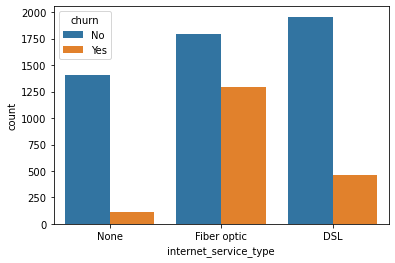

In [15]:
# looking at churn by internet_service_type
sns.countplot(x='internet_service_type', hue='churn', data=df)

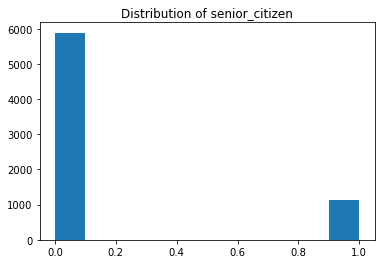

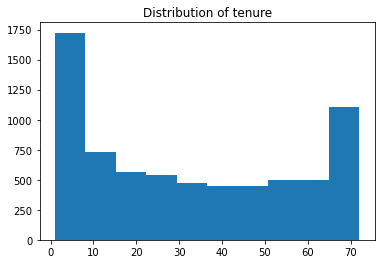

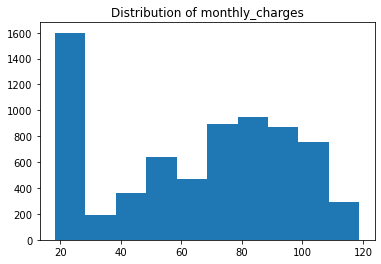

In [16]:
# taking a look at distributions
def num_distributions(df):
    '''
    This functions takes in a dataframe and displays
    the distribution of each numeric column.
    '''
    for col in df.columns:
        if df[col].dtype != 'object':
            plt.hist(df[col])
            plt.title(f'Distribution of {col}')
            plt.show()
num_distributions(df)

### Setting up my statistical tests

In [17]:
# define my alpha
alpha = .05

## Hypothesis test 1
### I want to see if churn has a relation to the month to month contract type

$H_0$ - There is no relation to churn and month to month contracts

$H_a$ - There is a relation to churn and month to month contracts

In [18]:
# establishing my baseline
baseline = train.churn.value_counts().nlargest(1) / train.shape[0]
print(f'My baseline accuracy is {round(baseline.values[0] * 100,2)}%.')

My baseline accuracy is 73.43%.


In [19]:
df.head() #check_yo_head

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,paperless_billing,monthly_charges,total_charges,churn,internet_service_type,contract_type,payment_type
0,Female,0,No,No,3,Yes,No,No,19.85,57.2,No,None,Month-to-month,Mailed check
1,Female,0,Yes,Yes,4,Yes,No,No,20.35,76.35,Yes,None,Month-to-month,Mailed check
2,Male,0,No,No,27,Yes,No,Yes,19.40,529.8,No,None,Month-to-month,Electronic check
3,Male,0,No,No,1,Yes,No,Yes,19.85,19.85,Yes,None,Month-to-month,Electronic check
4,Female,0,Yes,No,10,Yes,No,Yes,19.95,187.75,No,None,Month-to-month,Bank transfer (automatic)


In [20]:
# making a dummy variable for churn and contract_type

dummy_df = pd.get_dummies(df[['churn','contract_type']])
dummy_df.head() #check_yo_head

,churn_No,churn_Yes,contract_type_Month-to-month,contract_type_One year,contract_type_Two year
0,1,0,1,0,0
1,0,1,1,0,0
2,1,0,1,0,0
3,0,1,1,0,0
4,1,0,1,0,0


In [21]:
# concatenate the dummy_df dataframe above with the original df 

df = pd.concat([df, dummy_df], axis=1)
df.head() #check_yo_head

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,paperless_billing,monthly_charges,total_charges,churn,internet_service_type,contract_type,payment_type,churn_No,churn_Yes,contract_type_Month-to-month,contract_type_One year,contract_type_Two year
0,Female,0,No,No,3,Yes,No,No,19.85,57.2,No,None,Month-to-month,Mailed check,1,0,1,0,0
1,Female,0,Yes,Yes,4,Yes,No,No,20.35,76.35,Yes,None,Month-to-month,Mailed check,0,1,1,0,0
2,Male,0,No,No,27,Yes,No,Yes,19.40,529.8,No,None,Month-to-month,Electronic check,1,0,1,0,0
3,Male,0,No,No,1,Yes,No,Yes,19.85,19.85,Yes,None,Month-to-month,Electronic check,0,1,1,0,0
4,Female,0,Yes,No,10,Yes,No,Yes,19.95,187.75,No,None,Month-to-month,Bank transfer (automatic),1,0,1,0,0


In [22]:
observed = pd.crosstab(train.churn, train.contract_type)
observed

contract_type,Month-to-month,One year,Two year
churn,,,
No,1254,709,928
Yes,928,91,27


In [23]:
chi2, p ,degf, expected = stats.chi2_contingency(observed)
chi2, p

(655.4970548510178, 4.577444498483738e-143)

In [24]:
# comparing my p value to my alpha
if p < alpha:
    print("Reject null hypothesis, churn and contract_type are not independent")
else:
    print("Fail to reject null hypothesis, churn and contract_type are independent")

Reject null hypothesis, churn and contract_type are not independent


## Hypothesis test 2
### I want to see if churn has a relation to payment type

$H_0$ - There is no relation to churn and payment type

$H_a$ - There is a relation to churn and payment type

In [25]:
observed = pd.crosstab(train.churn, train.payment_type)
observed

payment_type,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check
churn,,,,
No,717,732,737,705
Yes,137,131,607,171


In [26]:
chi2, p ,degf, expected = stats.chi2_contingency(observed)
chi2, p

(366.38710341996045, 4.2183445638245506e-79)

In [27]:
# comparing my p value to my alpha
if p < alpha:
    print("Reject null hypothesis, churn and payment_type are not independent")
else:
    print("Fail to reject null hypothesis, churn and payment_type are independent")

Reject null hypothesis, churn and payment_type are not independent


## Modeling and Evaluation

- comparing models to my baseline accuracy 73.43%.

In [28]:
# making a copy of the train dataset to use for modeling
train_encoded = train.copy()

In [29]:
# setting up dummies for my modeling (train)

# selecting the columns that I will use

encoded_columns = ['gender','contract_type','partner','dependents','phone_service','multiple_lines','internet_service_type','payment_type']

# making dummy variables of the columns
dummy_df = pd.get_dummies(train_encoded[encoded_columns], dummy_na=False, drop_first=[True, True])

# combining the dummy columns
train_encoded = pd.concat([train_encoded, dummy_df], axis=1)

# dropping columns
train_encoded = train_encoded.drop(columns=encoded_columns)

train_encoded.head() #check_yo_head

,senior_citizen,tenure,paperless_billing,monthly_charges,total_charges,churn,gender_Male,contract_type_One year,contract_type_Two year,partner_Yes,dependents_Yes,phone_service_Yes,multiple_lines_No phone service,multiple_lines_Yes,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
6170,0,70,No,114.75,7842.3,No,1,0,1,1,1,1,0,1,1,0,1,0,0
2668,1,52,Yes,48.80,2555.05,No,1,0,0,0,0,0,1,0,0,0,1,0,0
5504,0,55,No,20.50,1177.95,No,1,0,1,1,1,1,0,0,0,1,0,0,1
3131,0,2,No,60.85,111.4,No,0,0,0,0,0,1,0,0,0,0,0,1,0
6450,0,72,No,42.10,2962,No,1,0,1,1,0,0,1,0,0,0,0,0,0


In [30]:
# setting up dummies for my modeling (validate)

# making a copy of the validate dataset
validate_encoded = validate.copy()

# making dummy variables of the columns
dummy_df = pd.get_dummies(validate_encoded[encoded_columns], dummy_na=False, drop_first=[True, True])

# combining the dummy columns
validate_encoded = pd.concat([validate_encoded, dummy_df], axis=1)

# dropping
validate_encoded = validate_encoded.drop(columns=encoded_columns)

validate_encoded.head()

,senior_citizen,tenure,paperless_billing,monthly_charges,total_charges,churn,gender_Male,contract_type_One year,contract_type_Two year,partner_Yes,dependents_Yes,phone_service_Yes,multiple_lines_No phone service,multiple_lines_Yes,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
914,1,33,Yes,100.60,3270.25,No,1,0,0,1,0,1,0,1,1,0,0,0,0
1981,0,18,No,101.30,1794.65,No,1,0,0,0,0,1,0,0,1,0,1,0,0
5306,0,65,No,67.05,4309.55,No,1,1,0,1,0,1,0,1,0,0,1,0,0
3982,0,22,No,20.30,467.15,No,1,1,0,0,0,1,0,0,0,1,1,0,0
5482,0,68,No,25.25,1728.2,No,1,0,1,1,0,1,0,1,0,1,0,0,0


In [31]:
# setting up dummies for my modeling (test)

# making a copy of the test dataset
test_encoded = test.copy()

# making dummy variables of the columns
dummy_df = pd.get_dummies(test_encoded[encoded_columns], dummy_na=False, drop_first=[True, True])

# combining the dummy columns
test_encoded = pd.concat([test_encoded, dummy_df], axis=1)

# dropping columns
test_encoded = test_encoded.drop(columns=encoded_columns)

test_encoded.head()

,senior_citizen,tenure,paperless_billing,monthly_charges,total_charges,churn,gender_Male,contract_type_One year,contract_type_Two year,partner_Yes,dependents_Yes,phone_service_Yes,multiple_lines_No phone service,multiple_lines_Yes,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
4056,0,13,No,20.20,273.25,No,0,1,0,0,0,1,0,0,0,1,0,0,1
6490,0,63,Yes,89.40,5597.65,No,1,0,1,1,1,1,0,1,0,0,1,0,0
6356,1,65,Yes,105.85,6725.5,No,0,0,1,1,0,1,0,0,1,0,1,0,0
5703,0,42,Yes,20.75,844.45,No,0,0,1,0,0,1,0,0,0,1,0,0,0
1458,0,18,Yes,75.60,1395.05,No,1,0,0,0,0,1,0,1,1,0,0,0,0


In [32]:
train_encoded.drop(columns='paperless_billing',inplace=True) # dropping columns

In [33]:
validate_encoded.drop(columns='paperless_billing',inplace=True) # dropping columns

In [37]:
X_train = train_encoded.drop(columns=['churn'])
y_train = train_encoded.churn

X_validate = validate_encoded.drop(columns=['churn'])
y_validate = validate_encoded.churn

X_test = test_encoded.drop(columns=['churn'])
y_test = test_encoded.churn

In [38]:
y_train.replace(to_replace=['yes','no'],value=[1,0], inplace=True) # replacing values to run model

In [39]:
y_test.replace(to_replace=['yes','no'],value=[1,0], inplace=True) # replacing values to run model

In [40]:
X_test.replace(to_replace=['yes','no'],value=[1,0], inplace=True) # replacing values to run model

In [41]:
# creating a decision tree model
clf = DecisionTreeClassifier(max_depth=3, random_state=123)

In [42]:
# fitting the model
clf = clf.fit(X_train, y_train)

In [43]:
# making a prediction on train obeservations
y_pred = clf.predict(X_train)
y_pred[0:5]

array(['No', 'No', 'No', 'No', 'No'], dtype=object)

In [44]:
# making a confusion matrix
confusion_matrix(y_train, y_pred)

array([[2683,  208],
       [ 598,  448]])

In [45]:
# making the classification report
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

          No       0.82      0.93      0.87      2891
         Yes       0.68      0.43      0.53      1046

    accuracy                           0.80      3937
   macro avg       0.75      0.68      0.70      3937
weighted avg       0.78      0.80      0.78      3937



In [46]:
# comparing my accuracy on train data
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(clf.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.80


In [47]:
# create random forest model
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=3, 
                            random_state=123)

In [48]:
#fit the model
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, min_samples_leaf=3, random_state=123)

In [49]:
# making predictions
y_pred = rf.predict(X_train)
y_pred[0:5]

array(['No', 'No', 'No', 'No', 'No'], dtype=object)

In [50]:
# estimate probability
y_pred_proba = rf.predict_proba(X_train)
y_pred_proba

array([[0.89185106, 0.10814894],
       [0.8102193 , 0.1897807 ],
       [0.96388494, 0.03611506],
       ...,
       [0.81900494, 0.18099506],
       [0.47752461, 0.52247539],
       [0.84987376, 0.15012624]])

In [51]:
# creating a confusion matrix
print(confusion_matrix(y_train, y_pred))

[[2724  167]
 [ 642  404]]


In [52]:
# creaiting a classification report
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

          No       0.81      0.94      0.87      2891
         Yes       0.71      0.39      0.50      1046

    accuracy                           0.79      3937
   macro avg       0.76      0.66      0.69      3937
weighted avg       0.78      0.79      0.77      3937



In [53]:
# comparing my accuracy
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))

Accuracy of random forest classifier on training set: 0.79


### Modeling notes
- baseline was 73% accuracy
- decision tree was 80% accuracy
- random forest was 79% accuracy
- Want to evaluate my decision tree model using my test data

In [62]:
# this is where I will evaluate my decision tree using my test data


In [59]:
# need to create a csv with predicted churn


## Conclusion

- Hypothesis 1: Reject null hypothesis, churn and contract_type are not independent

- Hypothesis 2: Reject null hypothesis, churn and payment_type are not independent

- Baseline accuracy is 73%

- Decision tree had highest accuracy 80%


### With more time I would like to:

- Complete the evaluate decision tree using test data

- Attempt a knn test to compare accuracy

- create a churn csv

- explore different correlations of churn 
